In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,precision_score, recall_score, confusion_matrix,accuracy_score,make_scorer,classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from imblearn.over_sampling import SMOTE,BorderlineSMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r'../DATA/heart-disease/heart_disease_uci.csv')
print(df.shape)
df.head()

(920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
df['num'].value_counts()

0    411
1    265
2    109
3    107
4     28
Name: num, dtype: int64

In [4]:
df.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [5]:
df.drop(['id','thal','ca','slope'],axis=1,inplace=True)

In [6]:
df = df[df['oldpeak'].isna()==False]

In [7]:
df['chol'].fillna(0,inplace=True)

In [8]:
df['fbs'].value_counts()

False    658
True     114
Name: fbs, dtype: int64

In [9]:
value_counts = df['fbs'].value_counts()

false_count = value_counts.get(False, 0)
true_count = value_counts.get(True, 0)
total_count = false_count + true_count
total_nan = df['fbs'].isna().sum()

false_proportion = false_count / total_count
true_proportion = true_count / total_count

num_false_to_fill = round(false_proportion * total_nan)
num_true_to_fill = total_nan - num_false_to_fill


values_to_fill = [False] * num_false_to_fill + [True] * num_true_to_fill
np.random.shuffle(values_to_fill)

df.loc[df['fbs'].isna(), 'fbs'] = values_to_fill

In [10]:
df.dropna(axis=0,inplace=True)

In [11]:
df.isna().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64

In [12]:
df.shape

(852, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852 entries, 0 to 919
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       852 non-null    int64  
 1   sex       852 non-null    object 
 2   dataset   852 non-null    object 
 3   cp        852 non-null    object 
 4   trestbps  852 non-null    float64
 5   chol      852 non-null    float64
 6   fbs       852 non-null    object 
 7   restecg   852 non-null    object 
 8   thalch    852 non-null    float64
 9   exang     852 non-null    object 
 10  oldpeak   852 non-null    float64
 11  num       852 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 86.5+ KB


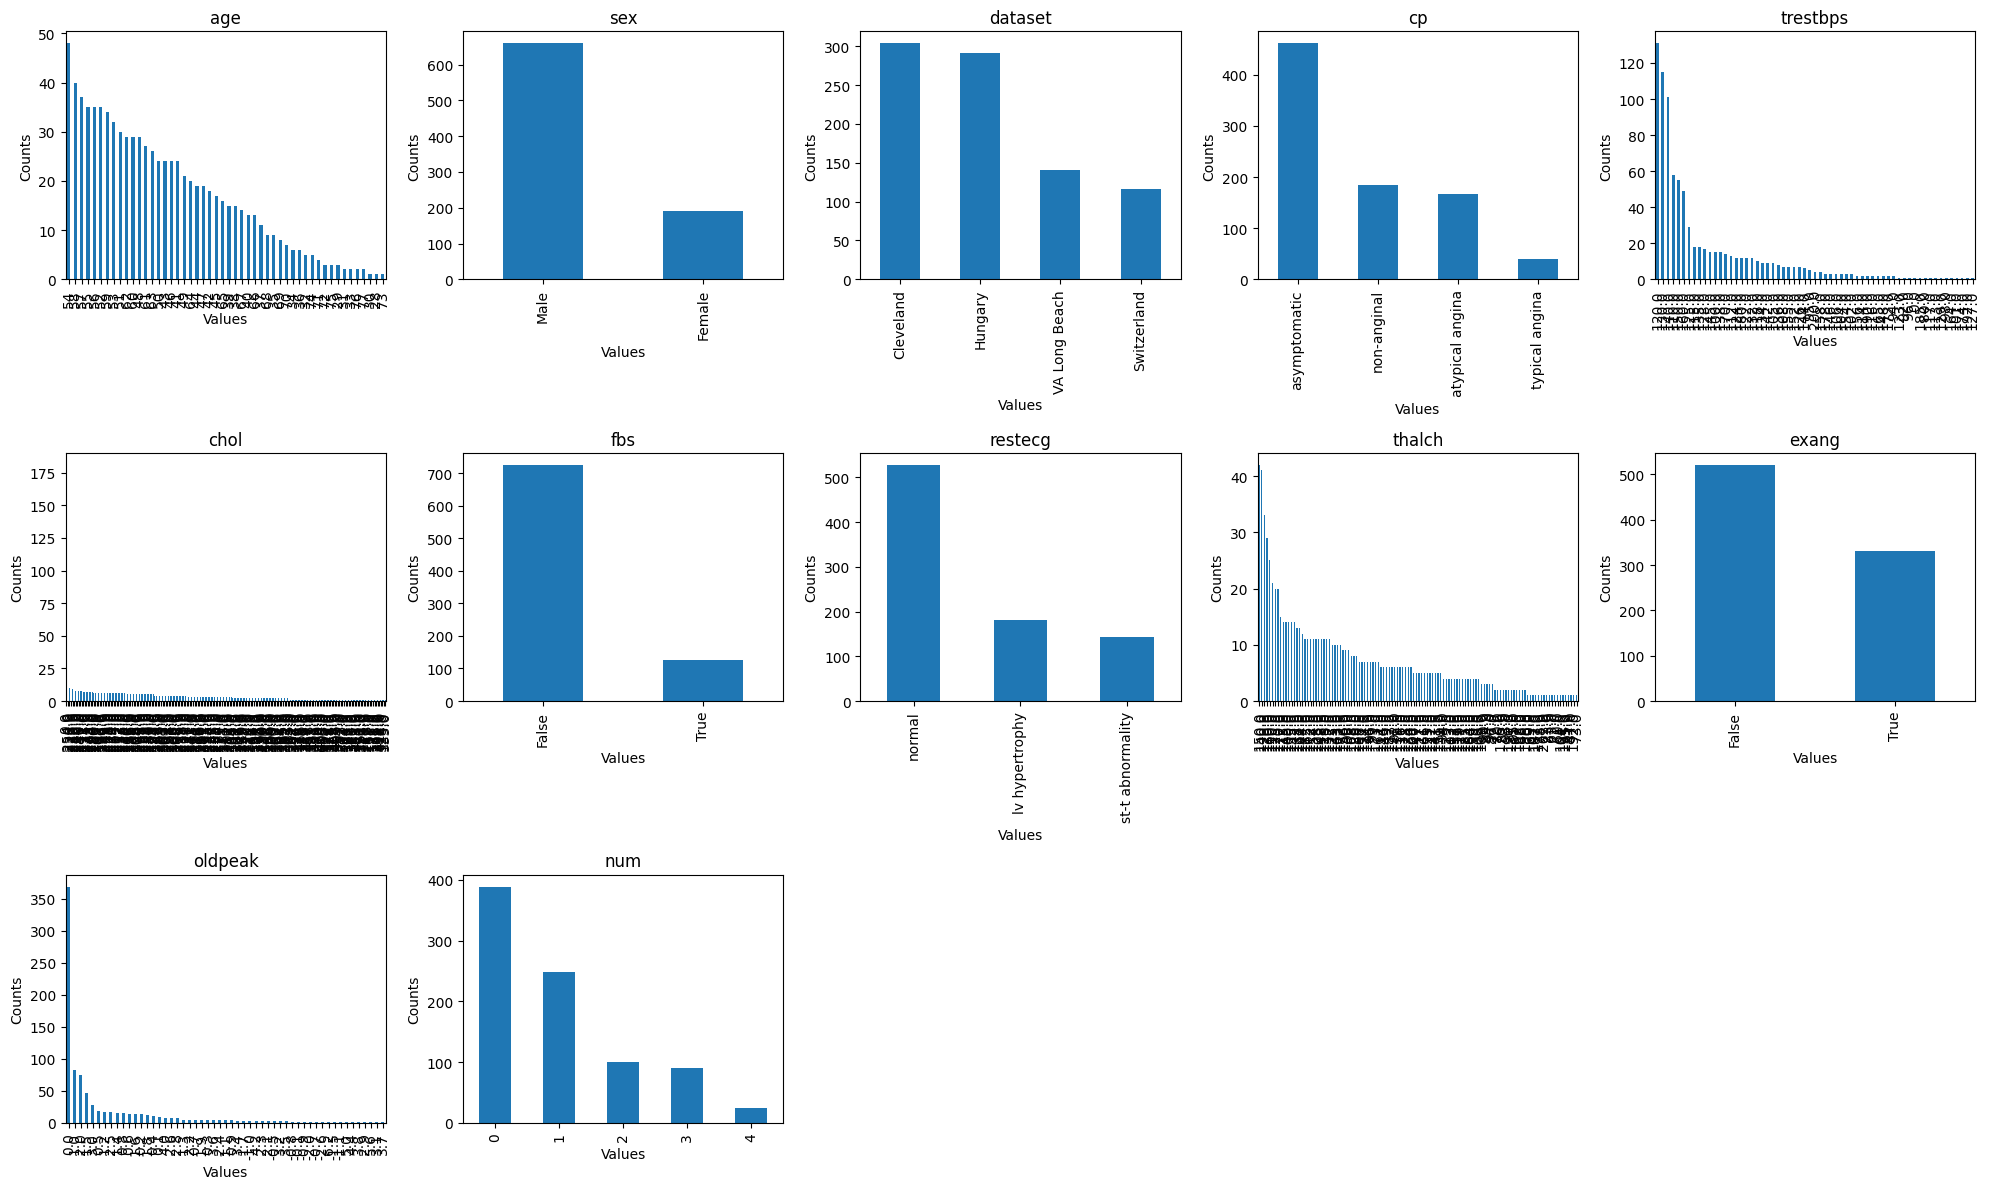

In [14]:
num_columns = len(df.columns)

# Set up the figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()  # Flatten the 3x5 array of axes

# Plot the value counts for each column
for i, col in enumerate(df.columns):
    value_counts = df[col].value_counts()
    ax = axes[i]
    value_counts.plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Counts')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
columns_to_encode = ['dataset', 'cp', 'restecg']

df= pd.get_dummies(df, columns=columns_to_encode)

In [16]:
df['sex'].replace({'Male':0,'Female':1},inplace=True)
df['fbs'].replace({'Male':0,'Female':1},inplace=True)
df['exang'].replace({'Male':0,'Female':1},inplace=True)

In [17]:
print(df.shape)

(852, 20)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852 entries, 0 to 919
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       852 non-null    int64  
 1   sex                       852 non-null    int64  
 2   trestbps                  852 non-null    float64
 3   chol                      852 non-null    float64
 4   fbs                       852 non-null    bool   
 5   thalch                    852 non-null    float64
 6   exang                     852 non-null    bool   
 7   oldpeak                   852 non-null    float64
 8   num                       852 non-null    int64  
 9   dataset_Cleveland         852 non-null    uint8  
 10  dataset_Hungary           852 non-null    uint8  
 11  dataset_Switzerland       852 non-null    uint8  
 12  dataset_VA Long Beach     852 non-null    uint8  
 13  cp_asymptomatic           852 non-null    uint8  
 14  cp_atypica

<AxesSubplot: >

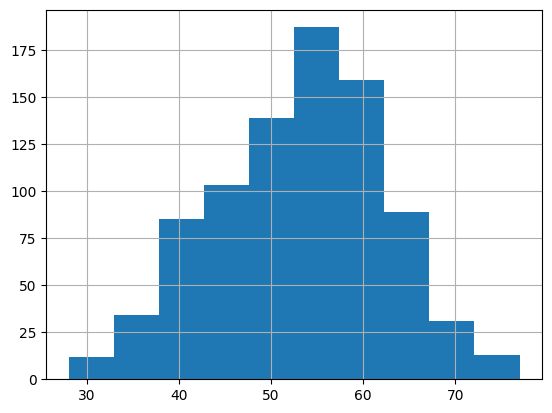

In [19]:
df['age'].hist()

In [20]:
X = df.drop('num', axis=1)
y =  df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
def evaluation(model,xtest,ytest):
    pred=model.predict(xtest)


    accuracy = accuracy_score(ytest, pred)
    precision = precision_score(ytest, pred, average='macro')
    recall = recall_score(ytest, pred, average='macro')



    conf_matrix = confusion_matrix(ytest, pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(classification_report(ytest, pred))
    classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.5614
Precision: 0.3602
Recall: 0.3577
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        73
           1       0.45      0.61      0.52        46
           2       0.25      0.08      0.12        25
           3       0.33      0.29      0.31        24
           4       0.00      0.00      0.00         3

    accuracy                           0.56       171
   macro avg       0.36      0.36      0.35       171
weighted avg       0.53      0.56      0.54       171



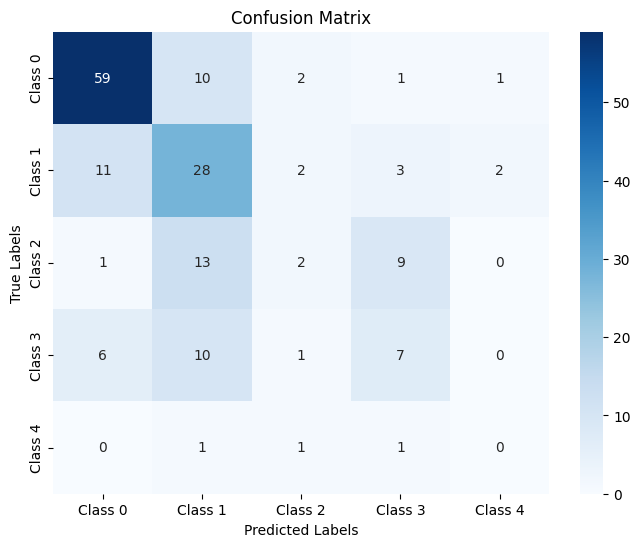

In [22]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

evaluation(LR,X_test,y_test)

Accuracy: 0.5439
Precision: 0.3186
Recall: 0.3199
              precision    recall  f1-score   support

           0       0.73      0.85      0.78        73
           1       0.39      0.59      0.47        46
           2       0.22      0.08      0.12        25
           3       0.25      0.08      0.12        24
           4       0.00      0.00      0.00         3

    accuracy                           0.54       171
   macro avg       0.32      0.32      0.30       171
weighted avg       0.48      0.54      0.50       171



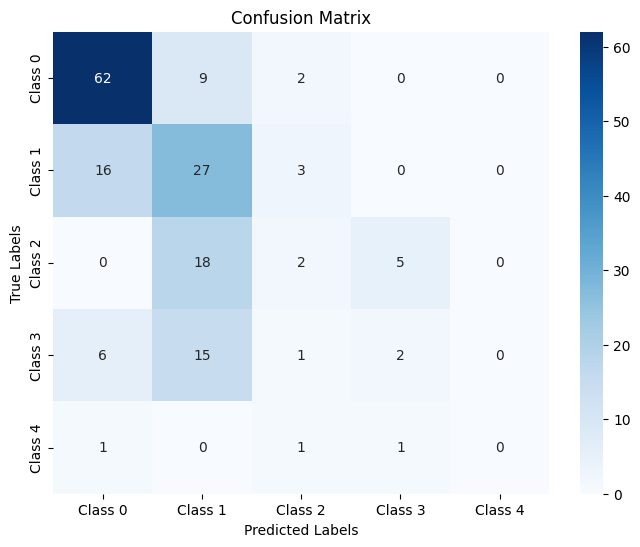

In [23]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)

evaluation(svc,X_test,y_test)

In [24]:
y_test.value_counts()

0    73
1    46
2    25
3    24
4     3
Name: num, dtype: int64

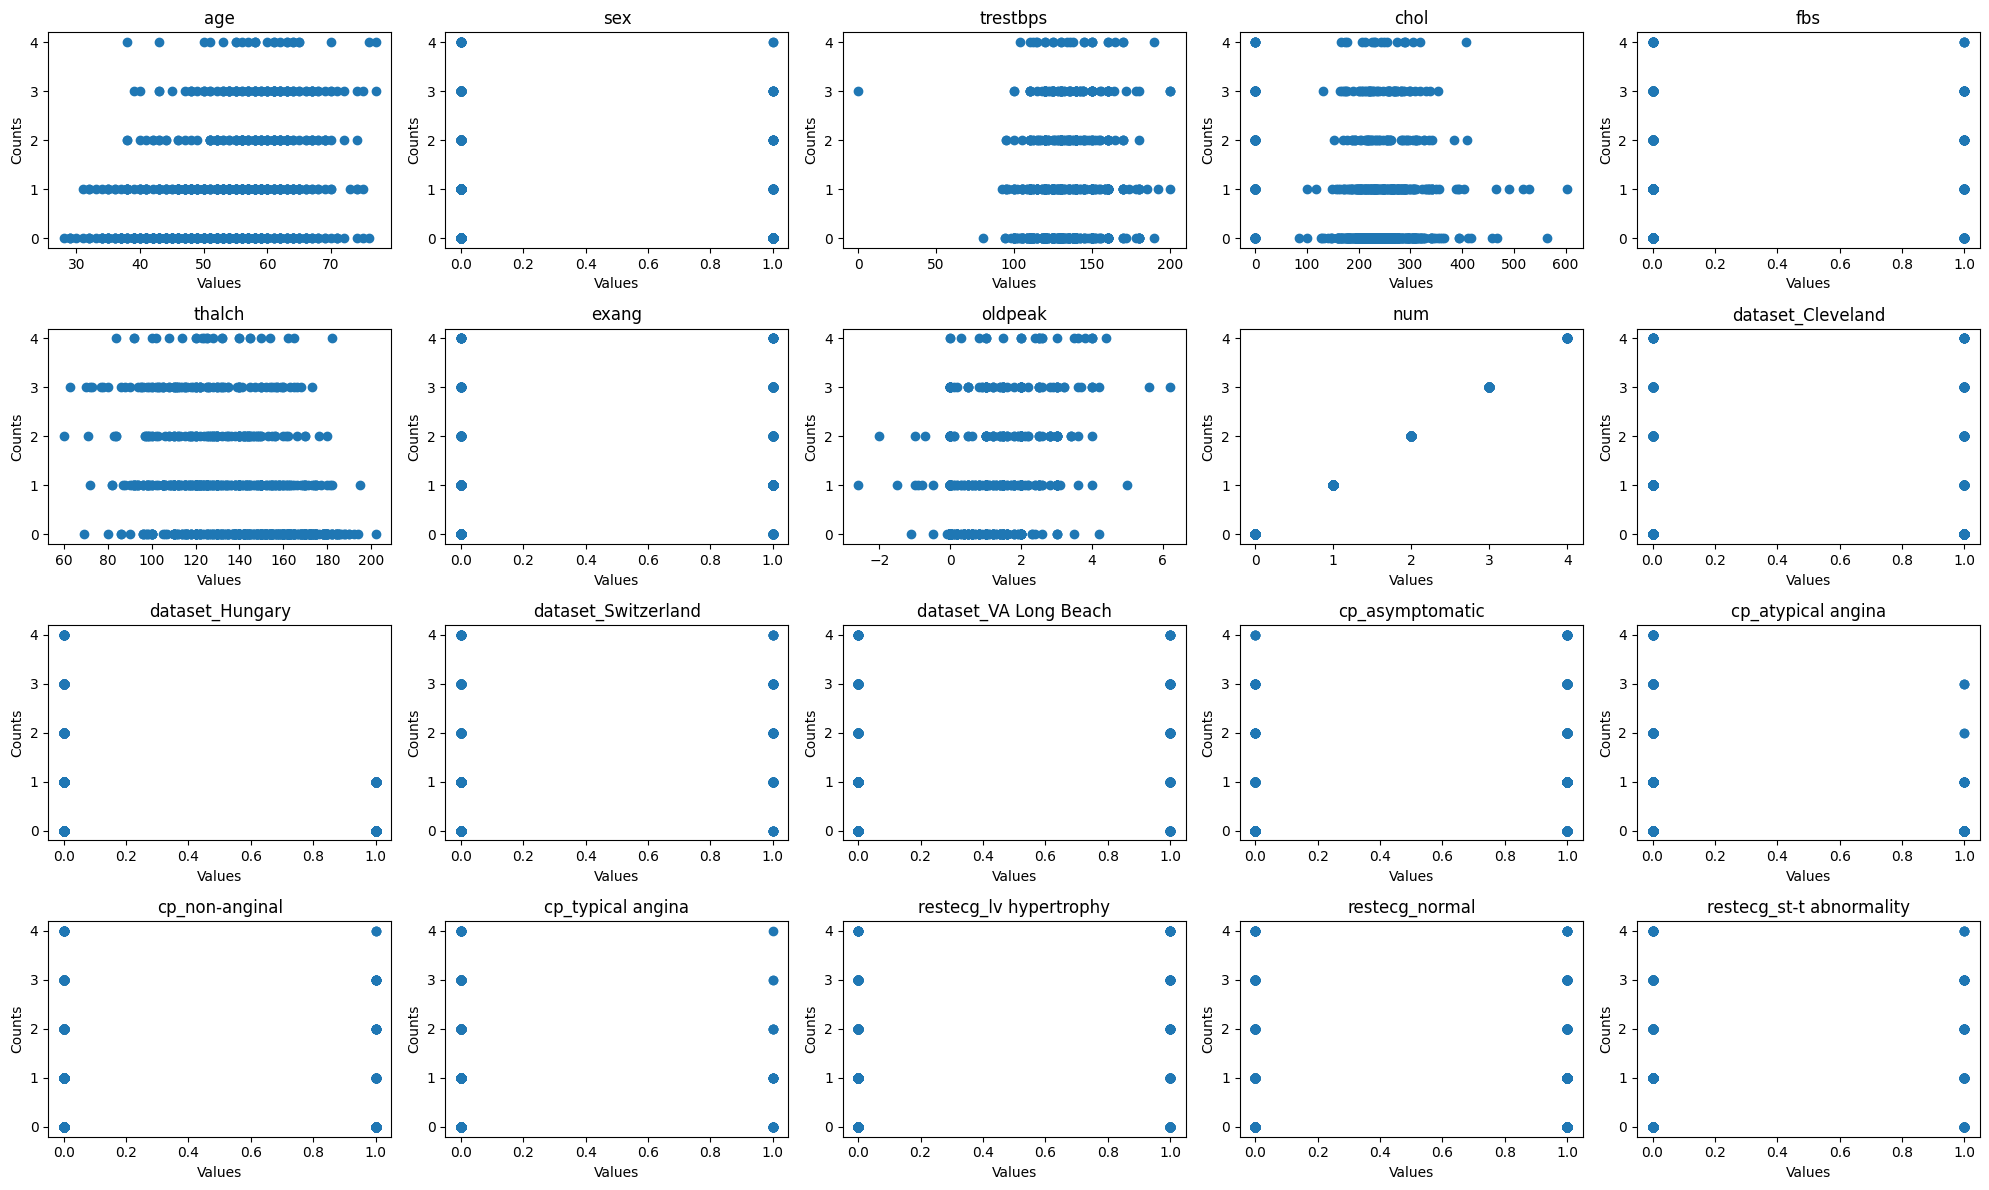

In [29]:
import matplotlib.pyplot as plt

num_columns = len(df.columns)

# Set up the figure and axes
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()  # Flatten the 3x5 array of axes

# Plot the value counts for each column
for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.scatter(df[col], df['num'])
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Counts')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [25]:
df['age_trestbps'] = df['age'] * df['trestbps']
df['age_bin'] = pd.cut(df['age'], bins=5, labels=False)
df['trestbps_bin'] = pd.cut(df['trestbps'], bins=5, labels=False)
df['sex_fbs'] = df['sex'] * df['fbs']


In [26]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']])

poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['age', 'trestbps', 'chol', 'thalch', 'oldpeak']))
df = pd.concat([df.drop(['age', 'trestbps', 'chol', 'thalch', 'oldpeak'], axis=1), poly_features_df], axis=1)

In [27]:
poly_features_df.shape

(852, 20)

In [28]:
df.shape

(896, 39)

In [29]:
df.dropna(axis=0,inplace=True)

Accuracy: 0.6173
Precision: 0.5605
Recall: 0.4157
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83        74
         1.0       0.59      0.56      0.57        48
         2.0       0.19      0.19      0.19        16
         3.0       0.24      0.20      0.22        20
         4.0       1.00      0.25      0.40         4

    accuracy                           0.62       162
   macro avg       0.56      0.42      0.44       162
weighted avg       0.61      0.62      0.61       162



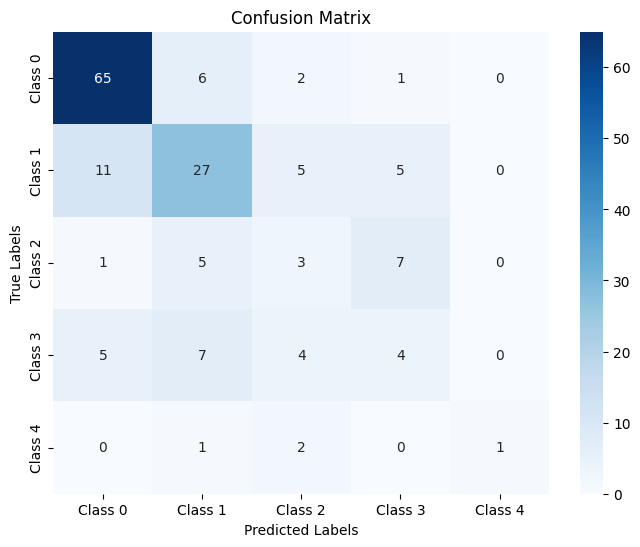

In [30]:
X2 = df.drop('num', axis=1)
y2 =  df['num']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)



LR2 = LogisticRegression()
LR2.fit(X_train2, y_train2)

evaluation(LR2,X_test2,y_test2)